# Using CMA-ME to Land the Lunar Lander Like an Airplane

In the [OpenAI Gym](https://gym.openai.com) toolkit, the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) is a task where an agent controls a spaceship to touch down gently within a goal zone near the bottom of the screen. Typically, agents in Lunar Lander take a direct approach, hovering straight down like this:

In [1]:
from IPython.display import display, HTML

def video(name):
    display(HTML(f'''
    <video width="360" height="auto" controls>
        <source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/{name}" type="video/mp4" />
    </video>
    '''))

video("lunar-lander-vertical.mp4")

Of course, this works fine, and the lander survives the trip down. However, there are less obvious (and more exciting!) ways to land. For instance, we can land like an airplane:

In [2]:
video("lunar-lander-left.mp4")

And we can also approach from the right:

In [3]:
video("lunar-lander-right.mp4")

The primary difference between these trajectories is their "point of impact," that is, the $x$-position of the lander when one of its legs hits the ground for the first time. In the vertical trajectory, the lander first impacts the ground at $x \approx -0.1$, and when approaching from the left and right, it first impacts at $x \approx -0.5$ and $x \approx 0.6$, respectively.

Though these trajectories look different, they all achieve good performance (200+), leading to an interesting insight: there are characteristics of a lunar lander that are not necessarily important for performance, but nonetheless determine the behavior of the lander. In Quality-Diversity (QD) terms, we call these behavior characteristics (BCs). In this tutorial, we will search for trajectories with different BCs using the pyribs implementation of [CMA-ME](https://arxiv.org/abs/1912.02400).

## Setup

First, we retrieve the dependencies. We freeze versions in order to make results reproducible. If this command updates or installs any dependencies, you may need to restart the kernel to make sure they are used. We retrieve `ribs[all]` instead of `ribs` in order to use the `ribs.visualize` module.

In [4]:
%pip install ribs[all] gym~=0.17.0 Box2D~=2.3.10 tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import time

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from ribs.archives import GridArchive
from ribs.emitters import ImprovementEmitter
from ribs.optimizers import Optimizer
from ribs.visualize import grid_archive_heatmap

## Problem Description

We treat the Lunar Lander as a Quality-Diversity (QD) problem. For the objective, we use the default provided by OpenAI gym, which rewards landing on the landing pad and penalizes engine usage.

For the behavior characteristics (BCs), we are interested in several factors at the time of "impact." We define impact to be the first time when either of the lunar lander's legs touches the ground. When this happens, we measure the following properties:

- $x$-position: This will lead to markedly different trajectories, as seen earlier.
- $y$-velocity: Different velocities will determine how hard the lander impacts the ground.

If the lunar lander never impacts the ground, we default the $x$-position to be the last $x$-position of the lander, and the $y$-velocity to be the maximum velocity of the lander (technically, the minimum, since the lander is going down and velocities are negative).

We will search for policies that produce high-performing trajectories with these characteristics. For simplicity, we will use a linear policy to control the lunar lander. As the lunar lander has discrete controls, the equation for this policy is:

$$a = argmax(Ws)$$

where $a$ is the action to take, $s$ is the state vector, and $W$ is our model, a matrix of weights that stays constant in each trajectory. Essentially, we transform the state to a vector with a "signal" for each possible action in the action space, and we choose the action with the highest signal. In searching for policies, we will really be searching for different models $W$.

Finally, to ensure we have an environment where landing with different trajectories works well (flat terrains are best), we have chosen a single seed (seed 1339) to use throughout the experiment, as shown below. Using the same seed also makes our environment deterministic. Since our policy and environment are both deterministic, we only have to simulate the policy once to find its performance.

In [6]:
env = gym.make("LunarLander-v2")
seed = 1339
action_dim = env.action_space.n
obs_dim = env.observation_space.shape[0]

We can summarize our problem description with the following `simulate` function, which takes in the model and simulates it in the Lunar Lander environment.

In [7]:
def simulate(env, model, seed=None):
    """Simulates the lunar lander model.

    Args:
        env (gym.Env): A copy of the lunar lander environment.
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    if seed is not None:
        env.seed(seed)

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = model.reshape((action_dim, obs_dim))

    total_reward = 0.0
    impact_x_pos = None
    impact_y_vel = None
    all_y_vels = []
    obs = env.reset()
    done = False

    while not done:
        action = np.argmax(model @ obs)  # Linear policy.
        obs, reward, done, info = env.step(action)
        total_reward += reward

        # Refer to the definition of state here:
        # https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py#L306
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the max y-vel (we use min since the lander
    # goes down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)

    return total_reward, impact_x_pos, impact_y_vel

## CMA-ME with pyribs

Covariance Matrix Adaptation MAP-Elites is a Quality-Diversity (QD) algorithm that leverages [CMA-ES](http://cma.gforge.inria.fr) to enhance exploration of the search and behavior space. To use CMA-ME to search for lunar lander policies, we will need the `GridArchive`, `ImprovementEmitter`, and `Optimizer` from pyribs.

First, the `GridArchive` stores solutions (i.e. models for our policy) in a rectangular grid. Each dimension of the `GridArchive` corresponds to a dimension in behavior space that is segmented into equally sized bins. As we have two BCs for our lunar lander, we have two dimensions in the `GridArchive`. The first dimension is the impact $x$-position, which ranges from -1 to 1, and the second is the impact $y$-velocity, which ranges from -3 (hitting the ground very quickly) to 0 (gently touching down). We divide both BCs into 50 bins below.

In [8]:
archive = GridArchive(
    [50, 50],  # 50 bins in each dimension.
    [(-1.0, 1.0), (-3.0, 0.0)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
)

Next, the `ImprovementEmitter` uses CMA-ES to search for policies that add new entries to the archive or improve existing ones. Since we do not have any prior knowledge of what the model will be, we set the initial model to be the zero vector, and we set the initial step size for CMA-ES to be 1.0, so that initial solutions are sampled from the standard Gaussian.

In [9]:
initial_model = np.zeros((action_dim, obs_dim))
emitters = [ImprovementEmitter(
    archive,
    initial_model.flatten(),
    1.0, # Initial step size.
)]

Above, we chose not to pass a ``batch_size``, i.e. the number of solutions for the emitter to generate on each call to its ``ask()`` method. Thus, the batch size was automatically calculated. We can check what it is:

In [10]:
print(emitters[0].batch_size)

14


Finally, the ``Optimizer`` connects the archive and emitters together.

In [11]:
optimizer = Optimizer(archive, emitters)

## QD Search

With the pyribs components defined, we start searching with CMA-ME. This loop should take 1-2 hours to run. Since the emitter has a batch size of 14, and we run 2500 iterations, so we will have to run 14 x 2500 = 35,000 lunar lander simulations. We also keep track of some logging info.

In [12]:
start_time = time.time()
total_itrs = 2500

for itr in tqdm(range(1, total_itrs + 1)):
    # Request models from the optimizer.
    sols = optimizer.ask()

    # Evaluate the models and record the objectives and BCs.
    objs, bcs = [], []
    for model in sols:
        obj, impact_x_pos, impact_y_vel = simulate(env, model, seed)
        objs.append(obj)
        bcs.append([impact_x_pos, impact_y_vel])

    # Send the results back to the optimizer.
    optimizer.tell(objs, bcs)

    # Logging.
    if itr % 100 == 0:
        df = archive.as_pandas(include_solutions=False)
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
        print(f"  - Archive Size: {len(df)}")
        print(f"  - Max Score: {df['objective'].max()}")

> 100 itrs completed after 258.41 s
  - Archive Size: 682
  - Max Score: 250.51727440194736
> 200 itrs completed after 443.52 s
  - Archive Size: 1032
  - Max Score: 250.51727440194736
> 300 itrs completed after 640.50 s
  - Archive Size: 1456
  - Max Score: 250.51727440194736
> 400 itrs completed after 871.11 s
  - Archive Size: 1860
  - Max Score: 250.51727440194736
> 500 itrs completed after 1012.12 s
  - Archive Size: 2118
  - Max Score: 250.51727440194736
> 600 itrs completed after 1159.45 s
  - Archive Size: 2186
  - Max Score: 250.51727440194736
> 700 itrs completed after 1366.61 s
  - Archive Size: 2271
  - Max Score: 250.51727440194736
> 800 itrs completed after 1471.11 s
  - Archive Size: 2308
  - Max Score: 250.51727440194736
> 900 itrs completed after 1951.48 s
  - Archive Size: 2328
  - Max Score: 250.51727440194736
> 1000 itrs completed after 2127.76 s
  - Archive Size: 2359
  - Max Score: 278.86567319136896
> 1100 itrs completed after 2264.06 s
  - Archive Size: 2363
  -

## Visualizing the Archive

Using `grid_archive_heatmap` from `ribs.visualize`, we can see a heatmap of the archive. The heatmap shows the BCs for which CMA-ME found a solution. At each BC, the color of the cell shows the objective value of the solution.

Text(0.5, 0, 'Impact x-position')

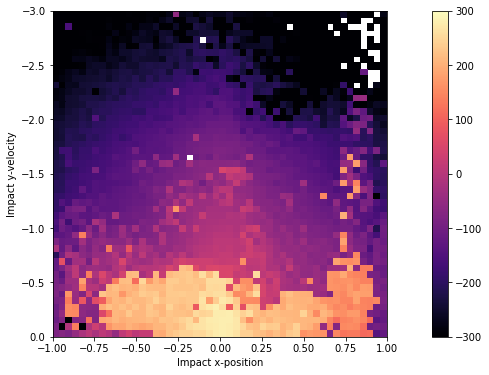

In [13]:
plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()  # Makes more sense if larger velocities are on top.
plt.ylabel("Impact y-velocity")
plt.xlabel("Impact x-position")

From this heatmap, we can make a few observations:

- CMA-ME found solutions for almost all bins in the archive. Empty bins show up as white.
- Most of the high-performing solutions have lower impact $y$-velocities (see the bright area at the bottom of the map). This is reasonable, as a lander that crashes into the ground probably would not stick the landing.
- The high-performing solutions are spread across a wide range of impact $x$-positions. The highest solutions seem to be at $x \approx 0$ (the bright spot in the middle). This makes sense since an impact $x$-position of 0 corresponds to the direct vertical approach. Nevertheless, there are many high-performing solutions that had other $x$-positions, and we will visualize them in the next section.

## Visualizing Individual Trajectories

To view the trajectories for different models, we can use the OpenAI Gym Monitor to record a video, and we can use IPython to display the video in the notebook. The following function shows how to do this.

In [14]:
import base64
import glob
import io


def display_video(model):
    """Displays a video of the model in the environment."""

    # Monitor records a video of the environment.
    video_env = gym.wrappers.Monitor(
        gym.make("LunarLander-v2"),
        "videos",  # Video directory.
        force=True,  # Overwrite existing videos.
        video_callable=lambda idx: True,  # Make all episodes be recorded.
    )
    simulate(video_env, model, seed)
    video_env.close()  # Save video.

    # Display the video with HTML. Though we use glob, there is only 1 video.
    for video_file in glob.glob("videos/*.mp4"):
        video = io.open(video_file, 'rb').read()
        encoded = base64.b64encode(video).decode("ascii")
        display(
            HTML(f'''
            <video width="360" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>
        '''))

Using the ``elite_with_behavior`` method on the archive, we can find models that had certain BCs. First, we can retrieve one that impacted on the left (-0.4) with low velocity (-0.10).

In [15]:
sol, obj, beh = archive.elite_with_behavior([-0.4, -0.10])
display_video(sol)

We can also find one that impacted on the right (0.4) with low velocity.

In [16]:
sol, obj, beh = archive.elite_with_behavior([0.4, -0.10])
display_video(sol)

And the regular vertical landing, which happens when the impact $x$-position is around 0.

In [17]:
sol, obj, beh = archive.elite_with_behavior([0.0, -0.10])
display_video(sol)

As the archive has ~2500 solutions, we cannot view them all, so we can also filter for high-performing solutions. We choose solutions that scored above 200 because 200 is the threshold for the problem to be considered [solved](http://gym.openai.com/envs/LunarLander-v2/). Note that many solutions that are considered "solved" do not land on the landing pad.

In [18]:
df = archive.as_pandas()
high_performing = df[df["objective"] > 200].sort_values("objective", ascending=False)
display(high_performing)

,index_0,index_1,behavior_0,behavior_1,objective,solution_0,solution_1,solution_2,solution_3,solution_4,...,solution_22,solution_23,solution_24,solution_25,solution_26,solution_27,solution_28,solution_29,solution_30,solution_31
448,24,45,-0.018159,-0.272206,281.654841,2.586706,-0.718504,8.613213,6.499991,-7.073494,...,-5.541425,-2.104530,-3.416419,1.226467,-10.251567,-0.676146,4.749759,-0.725755,2.289303,-4.226534
285,25,49,0.031188,-0.043016,280.355146,3.341403,-1.168379,5.271024,5.582920,-5.211313,...,-0.588160,-1.979921,-4.860502,0.479535,-8.027935,-1.842997,4.392227,4.604686,0.148938,-6.923312
419,26,46,0.051964,-0.182857,280.077403,2.689637,2.374289,6.777182,3.999120,-4.968189,...,-1.343599,-4.827180,-3.449151,1.393628,-9.819729,-0.899647,3.420844,7.111502,-1.726419,-8.353486
475,26,47,0.067905,-0.158977,279.518954,2.634522,2.148642,6.275252,3.103318,-4.391057,...,-2.162702,-1.797081,-5.907262,2.064154,-11.026719,0.099550,4.903504,6.115042,-0.884995,-9.838141
319,25,48,0.008590,-0.091840,279.346544,2.263444,2.144246,6.032625,2.636962,-3.788853,...,-2.162425,-2.214902,-4.730471,0.629181,-9.931766,0.085180,5.398828,7.293734,-1.149870,-9.290771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,32,49,0.289786,-0.029959,202.222056,0.183937,-0.903405,3.444648,7.165769,-11.127901,...,-0.080603,2.481627,5.581690,9.801884,-10.661131,6.904445,10.339604,-0.167207,3.652238,3.650645
533,11,48,-0.537031,-0.088645,202.021492,9.782526,-11.089103,12.310885,5.098358,-23.904792,...,2.428322,8.371140,-1.128302,5.191470,-0.006578,11.721138,10.961595,-3.919477,1.791289,1.010010
2271,36,43,0.474735,-0.402656,201.787020,13.318072,-2.973220,0.972119,-0.825084,-2.682556,...,-4.244148,13.731882,2.446331,15.636418,-11.225717,2.751701,13.855660,-0.163605,7.840776,3.138020
663,12,42,-0.481990,-0.445462,201.353448,3.367835,-8.977209,13.043231,-1.567297,-17.768055,...,2.553707,8.532154,-1.527147,0.604391,-0.610616,6.840217,9.598409,-4.487092,2.885582,2.173754


To visualize some of these, we pick some rows and extract the solutions.

In [19]:
rows = high_performing.iloc[[0, 50, -1]]
display(rows.loc[:, :"objective"])
row_sols = np.array(rows.loc[:, "solution_0":])

for sol in row_sols:
    display_video(sol)

,index_0,index_1,behavior_0,behavior_1,objective
448,24,45,-0.018159,-0.272206,281.654841
511,23,46,-0.070021,-0.194890,250.093446
2260,43,31,0.749033,-1.109503,200.058420


## Conclusion

Often, there are many interesting solutions to a problem, but the properties of these solutions cannot easily be quantified as part of the objective. In such cases, a QD algorithm can help search for solutions that have a wide variety of these properties. In this tutorial, we showed that this is the case for the lunar lander environment. Using CMA-ME, we searched for lunar lander trajectories with a wide variety of impact characteristics. Though these trajectories are vastly different, they all perform well.

For extending this tutorial, we suggest the following:

- Replace the impact characteristics with your own BCs. What other properties might be interesting for the lunar lander?
- Try different terrains by changing the seed. For instance, if the environment has valleys, can the lander learn to go into this valley and glide back up?
- Use other gym environments. What BCs could you use in an environment like `BipedalWalker-v2`?

## Credits

This tutorial is based on a [poster](https://1l7puj10vwe3zflo2jsktkit-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/S20-Klapsis-Poster.pdf) created by Nikitas Klapsis as part of USC's 2020 SHINE program.